# Лабораторная работа №2 Проведение исследований с логистической и линейной регрессией

Подключим все необходимые библиотеки

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, root_mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Загрузим датасет для классификации

In [ ]:
kagglehub.dataset_download("yasserh/wine-quality-dataset")
kagglehub.dataset_download("shree1992/housedata")

100%|██████████| 21.5k/21.5k [00:00<00:00, 25.9MB/s]

Extracting files...


100%|██████████| 432k/432k [00:00<00:00, 54.8MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/shree1992/housedata/versions/2'

In [ ]:
df_class = pd.read_csv("/root/.cache/kagglehub/datasets/yasserh/wine-quality-dataset/versions/1/WineQT.csv")
df_class = df_class.drop(columns=['Id'])
y_class = df_class['quality']
X_class = df_class.drop(columns=['quality'])
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=7575, shuffle = True
)
scaler = StandardScaler()
X_train_class = scaler.fit_transform(X_train_class)
X_test_class = scaler.transform(X_test_class)

In [ ]:
df_reg = pd.read_csv("/root/.cache/kagglehub/datasets/shree1992/housedata/versions/2/data.csv")
df_reg = df_reg.drop(columns=['street', 'country', 'date'])

categorical_features = ['city', 'statezip']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoder.fit(df_reg[categorical_features])
encoded_cols = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoder.transform(df_reg[categorical_features]), columns=encoded_cols, index=df_reg.index)

df_reg = pd.concat([df_reg.drop(columns=categorical_features), encoded_df], axis=1)

y_reg = df_reg['price']
X_reg = df_reg.drop(columns=['price'])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=4668, shuffle=True
)
scaler_reg = StandardScaler()
X_train_reg = scaler_reg.fit_transform(X_train_reg)
X_test_reg = scaler_reg.transform(X_test_reg)

## 2.	Создание бейзлайна и оценка качества

### A.	Обучить модели из sklearn

Обучим модель для классификации

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [ ]:
logistic_model_class = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=45355)
logistic_model_class.fit(X_train_class, y_train_class)

LogisticRegression(max_iter=10000, random_state=45355)

Теперь обучим модели для регрессии

In [ ]:
linear_model_reg = LinearRegression()
linear_model_reg.fit(X_train_reg, y_train_reg)

LinearRegression()

### B.	Оценить качество моделей

Результаты для классификации

In [ ]:
y_pred_logistic_class = logistic_model_class.predict(X_test_class)
logistic_accuracy_class = accuracy_score(y_test_class, y_pred_logistic_class)
logistic_f1_class = f1_score(y_test_class, y_pred_logistic_class, average='weighted')
print("Classification - Logistic Regression Results:")
print(f"Accuracy: {logistic_accuracy_class:.4f}")
print(f"F1 Score: {logistic_f1_class:.4f}\n")

Classification - Logistic Regression Results:
Accuracy: 0.5590
F1 Score: 0.5337



В принципе обе модели показали себя одинаково, но логистическая регрессия показала себя лучше (как мы видели в прошлой лабораторной явных линейных зависимостей в датасете нет)

Теперь рассмотрим регрессионную задачу

In [ ]:
y_pred_linear_reg = linear_model_reg.predict(X_test_reg)
linear_rmse_reg = root_mean_squared_error(y_test_reg, y_pred_linear_reg)
linear_r2_reg = r2_score(y_test_reg, y_pred_linear_reg)
print("Regression - Linear Regression Results:")
print(f"RMSE: {linear_rmse_reg:.4f}")
print(f"R^2 Score: {linear_r2_reg:.4f}")

Regression - Linear Regression Results:
RMSE: 749683.7443
R^2 Score: 0.1210


Обе модели по показали низкую точность. Я связываю это с особенностями датасета и не проработанным бейзланом

## 3. Улучшение бейзлайна и оценка качества

Опять выведем хитмапы

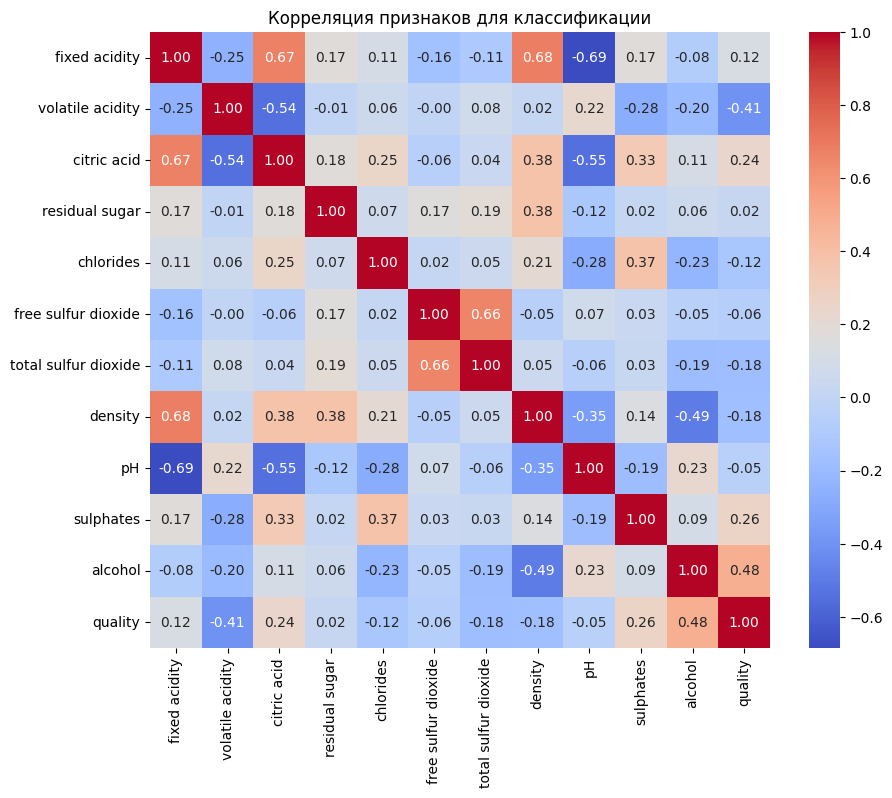

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_class.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляция признаков для классификации")
plt.show()

Возможно стоит попробовать отбросить слабо коррелирующие признаки, а сильно коррелирующие использовать для создания новых признаков (residual sugar и pH)

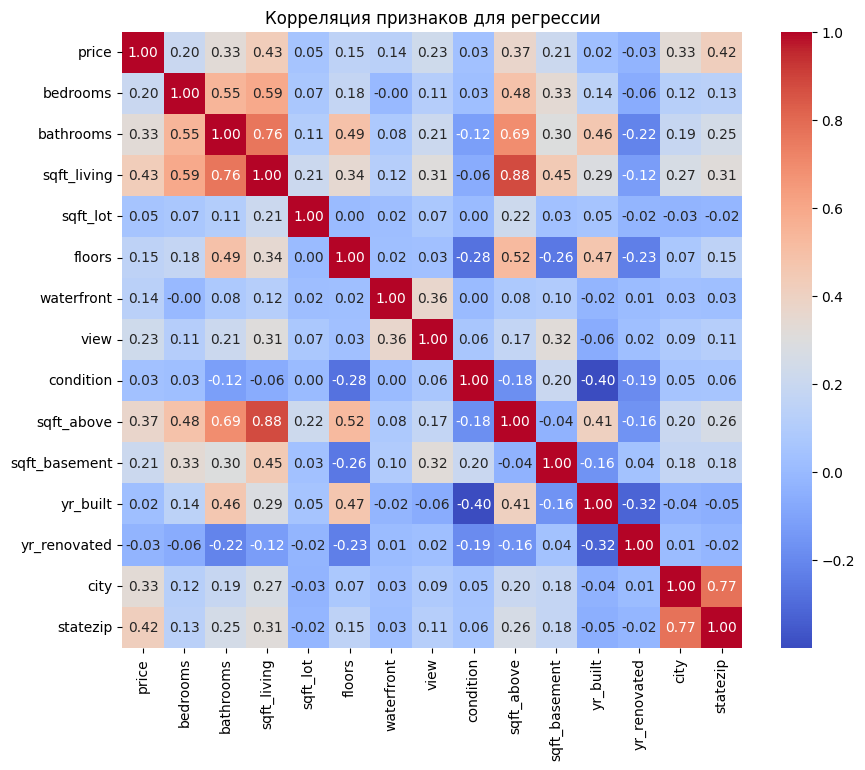

In [ ]:
df_reg = pd.read_csv("/root/.cache/kagglehub/datasets/shree1992/housedata/versions/2/data.csv")
df_reg = df_reg.drop(columns=['street', 'country', 'date'])

categorical_features = ['city', 'statezip']

for feature in categorical_features:
    mean_target = df_reg.groupby(feature)['price'].mean()
    df_reg[feature] = df_reg[feature].map(mean_target)
plt.figure(figsize=(10, 8))
sns.heatmap(df_reg.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляция признаков для регрессии")
plt.show()

С прошлой лабораторной новых идей не появилось. Попробуем отбросить слабокоррелирующие признаки

Графики выбросов для данных классификации


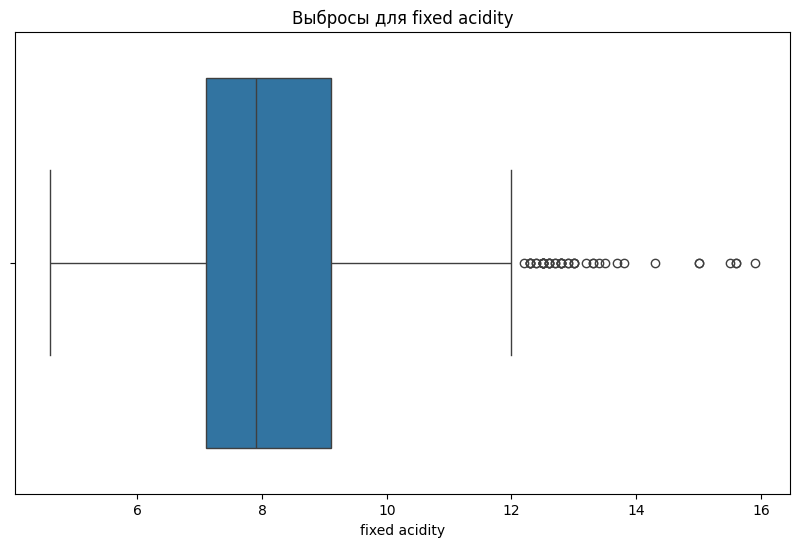

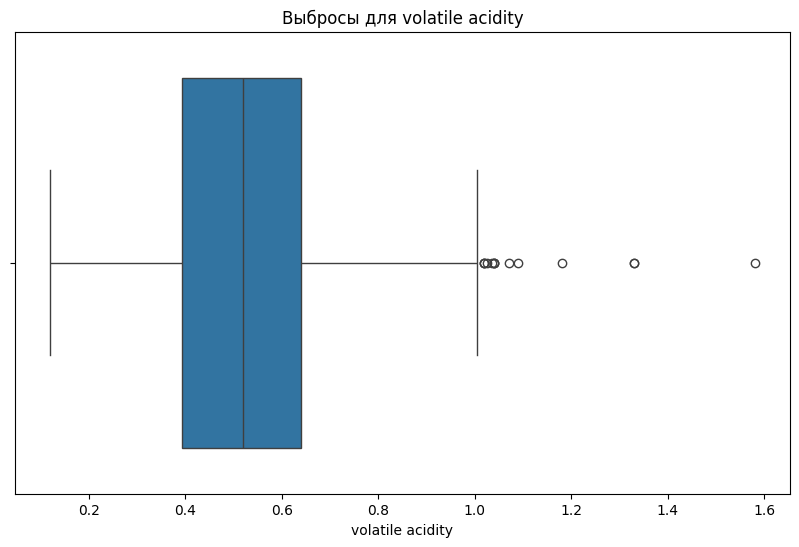

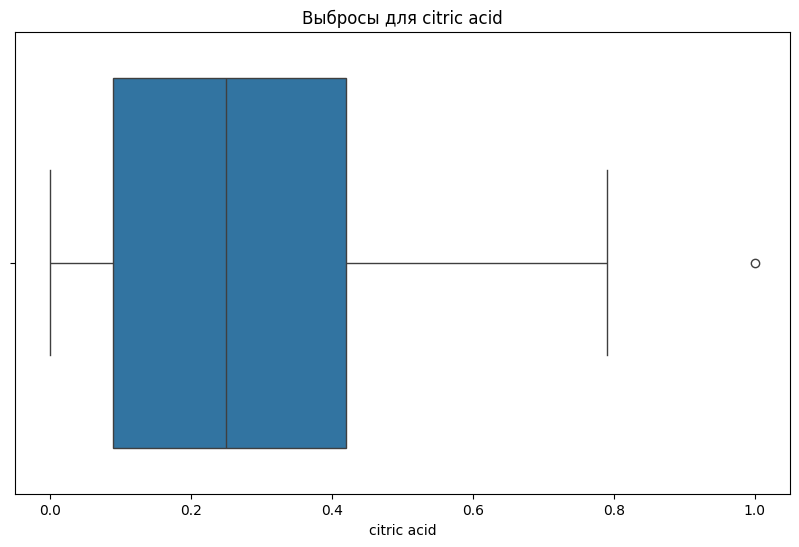

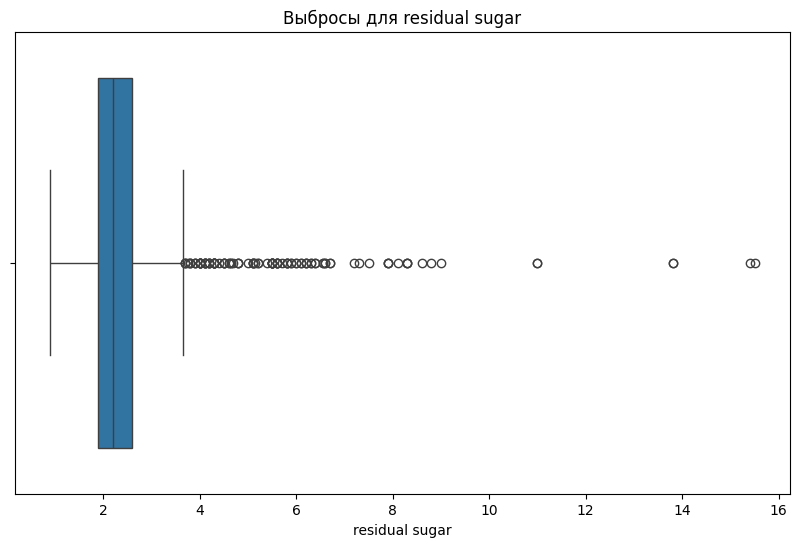

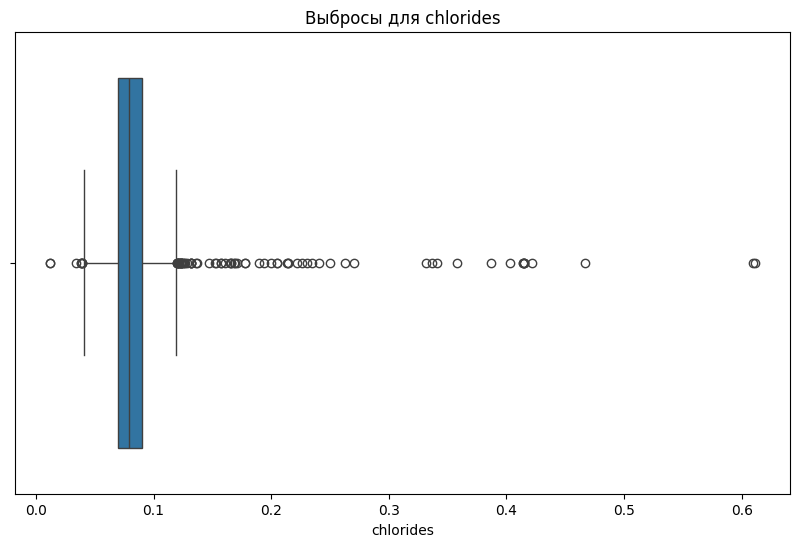

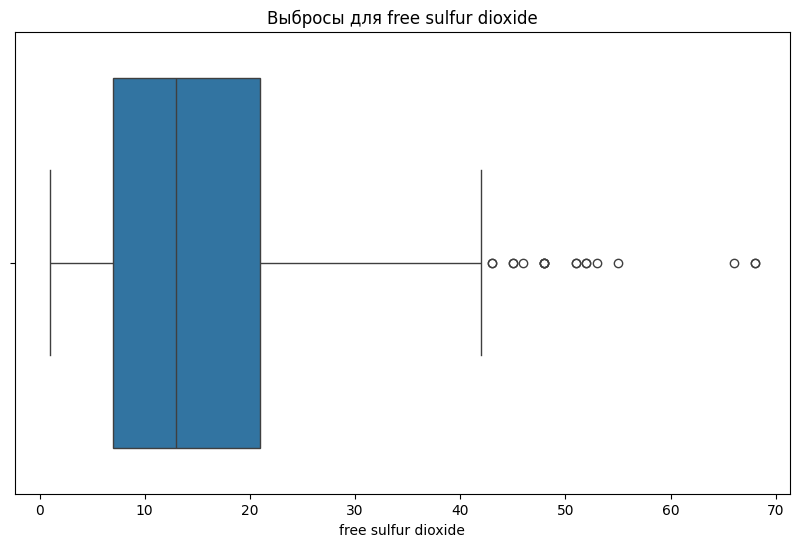

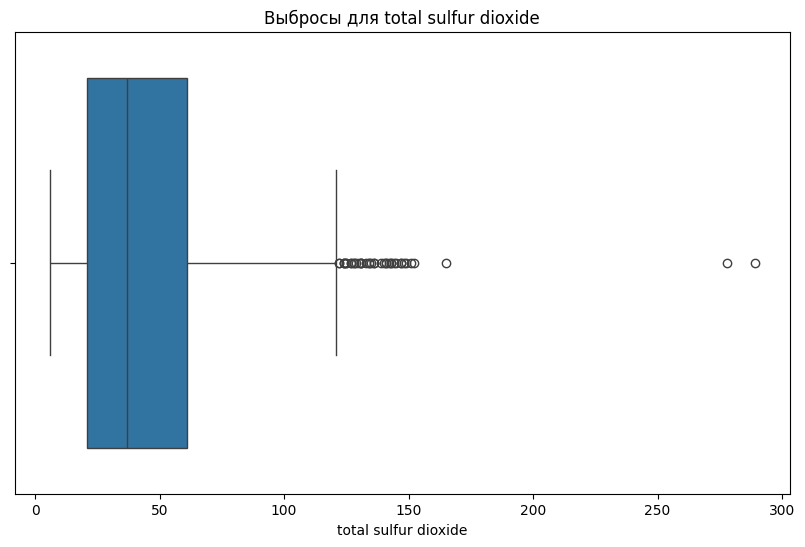

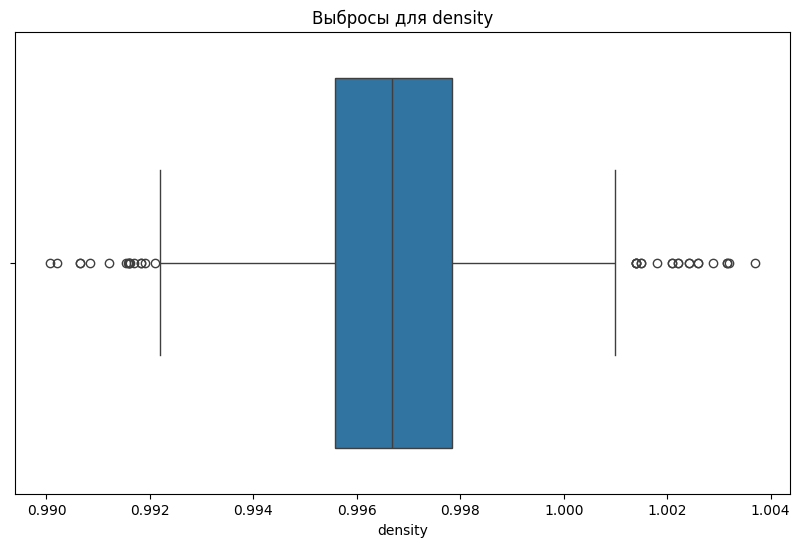

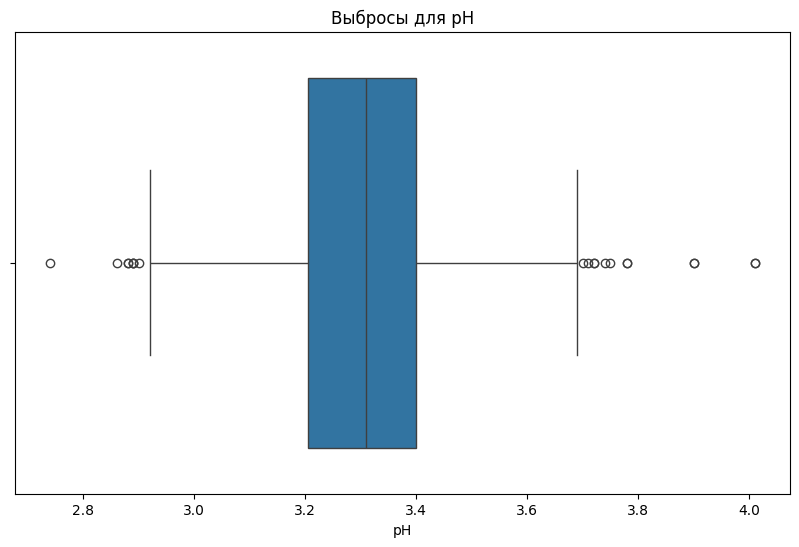

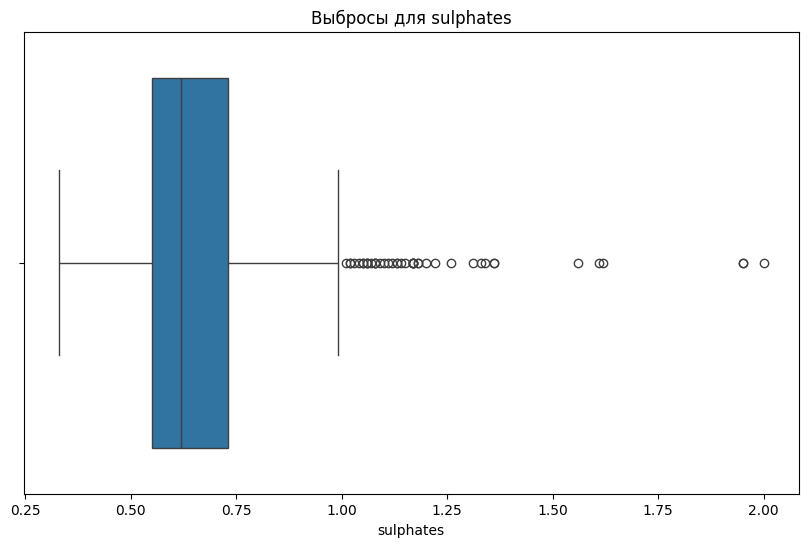

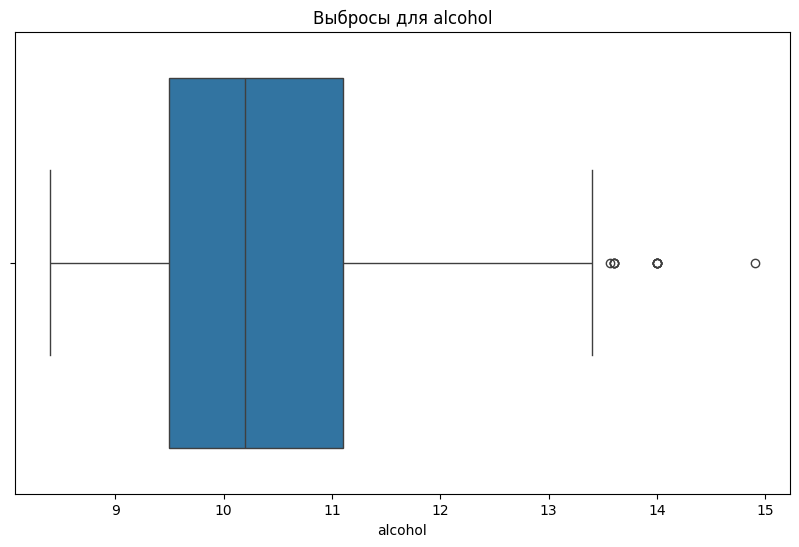

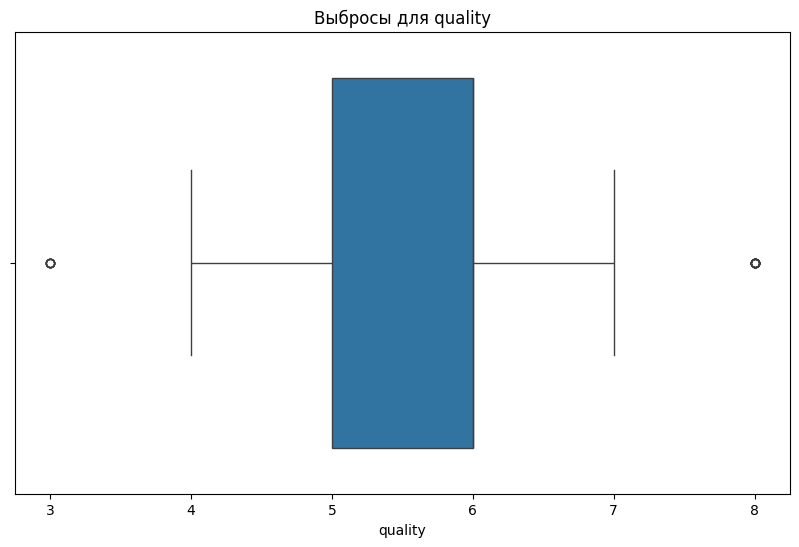

In [ ]:
print("Графики выбросов для данных классификации")
for column in df_class.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_class[column])
    plt.title(f"Выбросы для {column}")
    plt.show()

Изучив "ящики с усами" я предположил следующие методы для улучшения бейзлайна:
1. Убрать признаки residual sugar, pH
2. Прологарифмируем признаки chlorides и sulphates
3. Создадим признак-отношение Free Sulfur Dioxide и Total Sulfur Dioxide
4. Попробуем расширить классы quality с помощью oversampling

Графики выбросов для данных регрессии


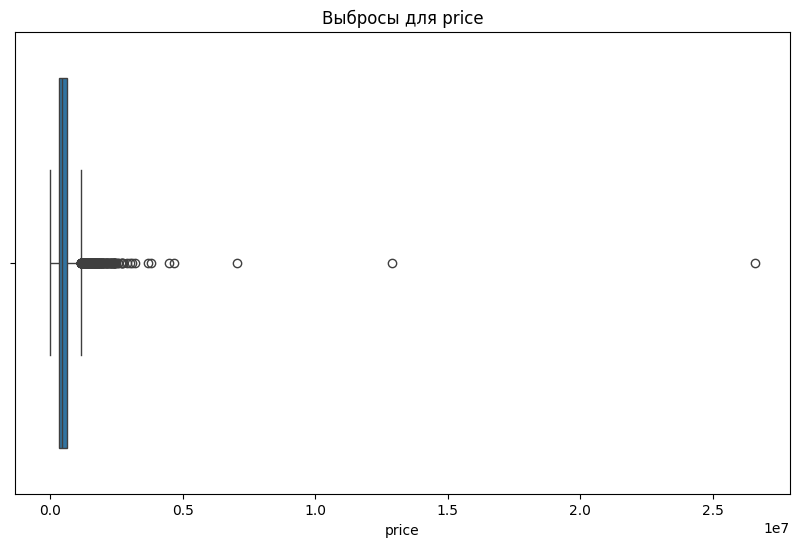

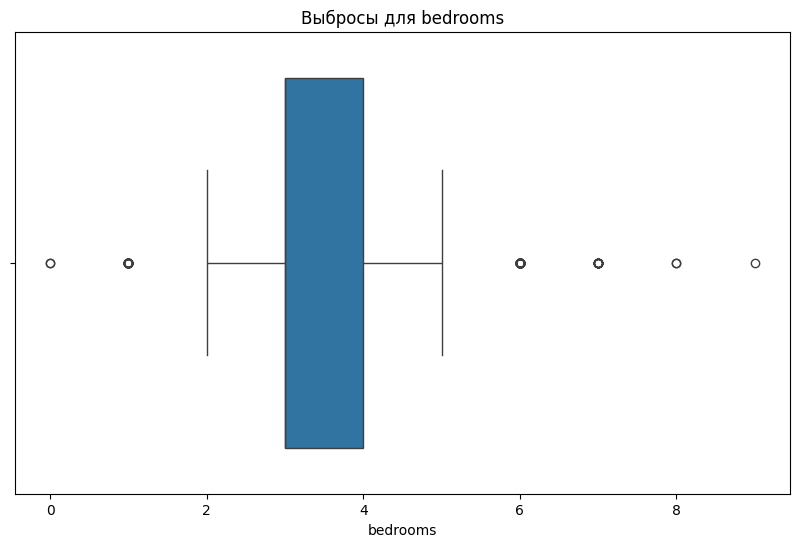

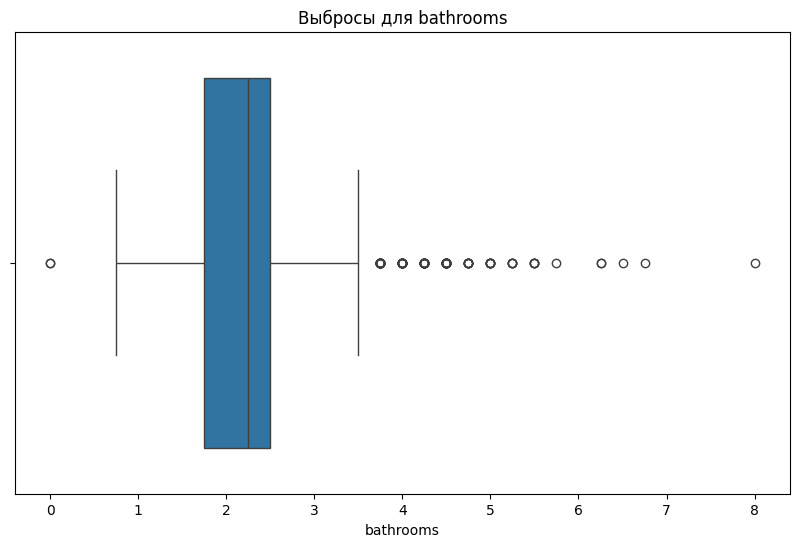

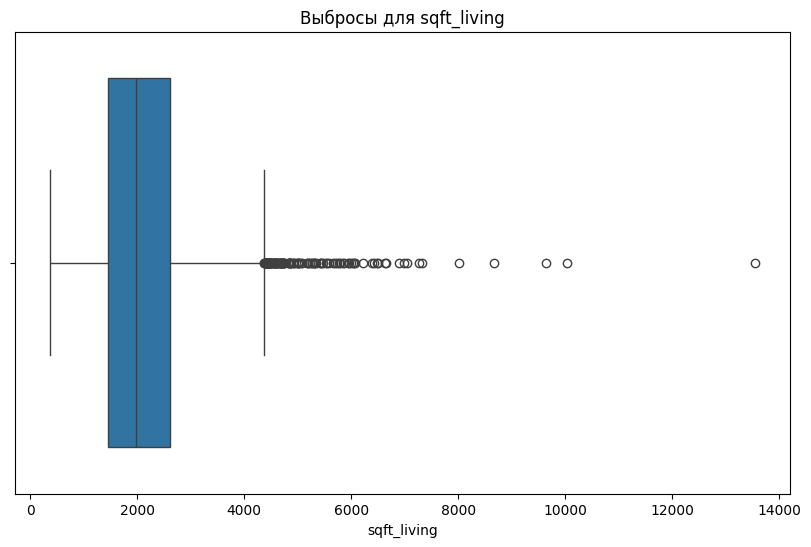

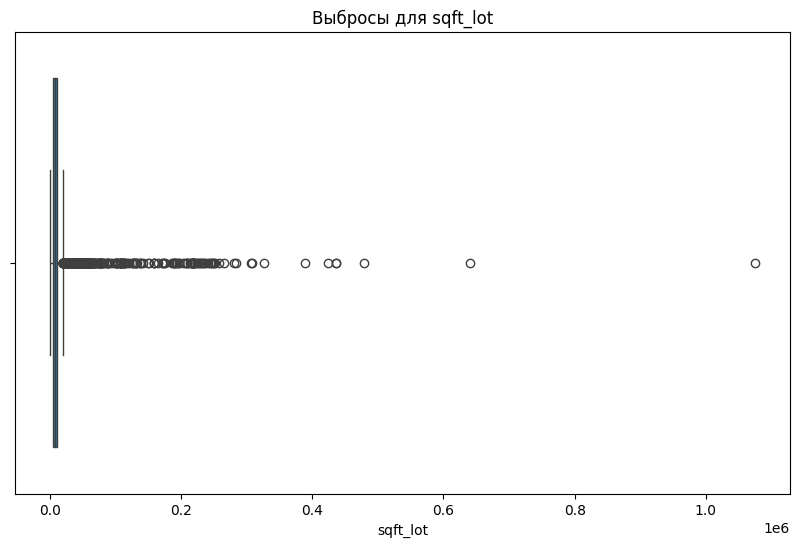

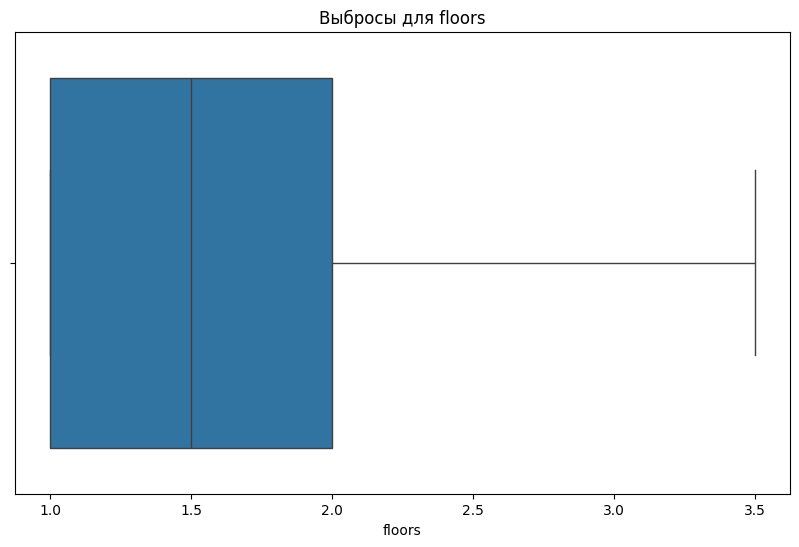

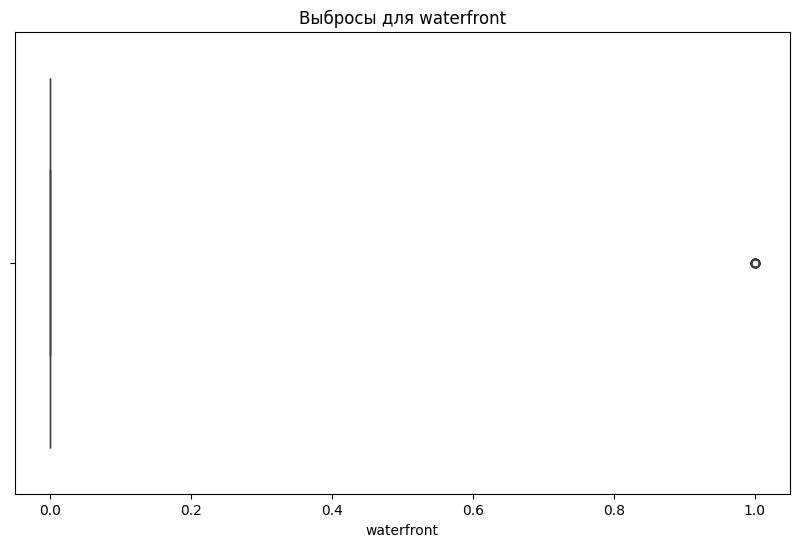

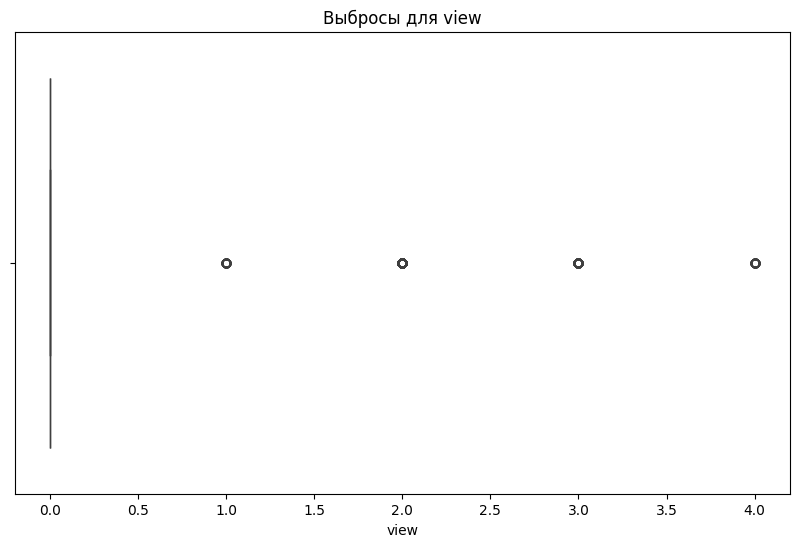

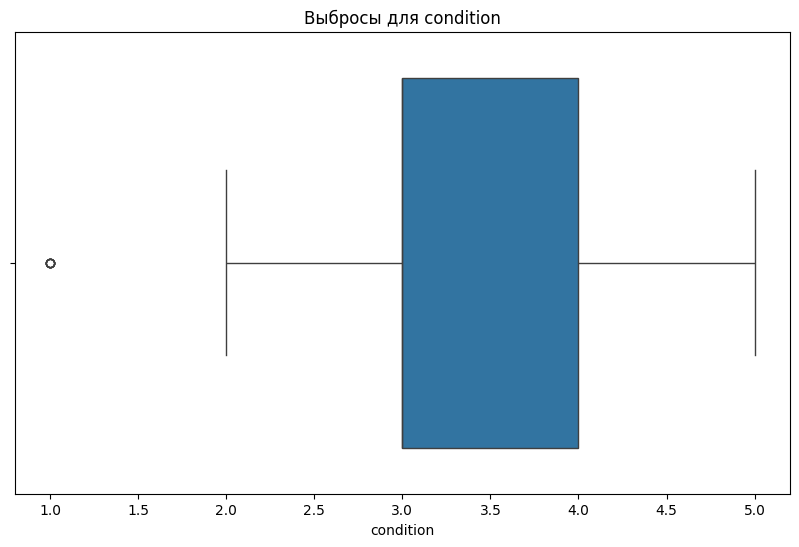

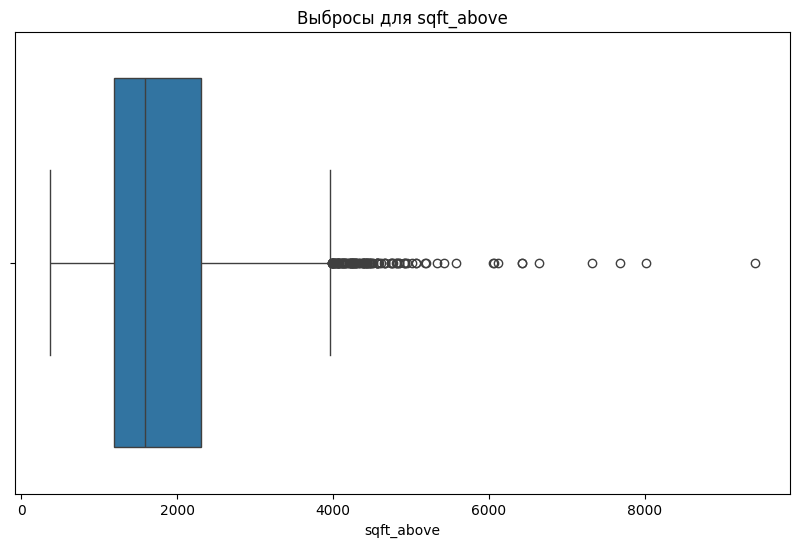

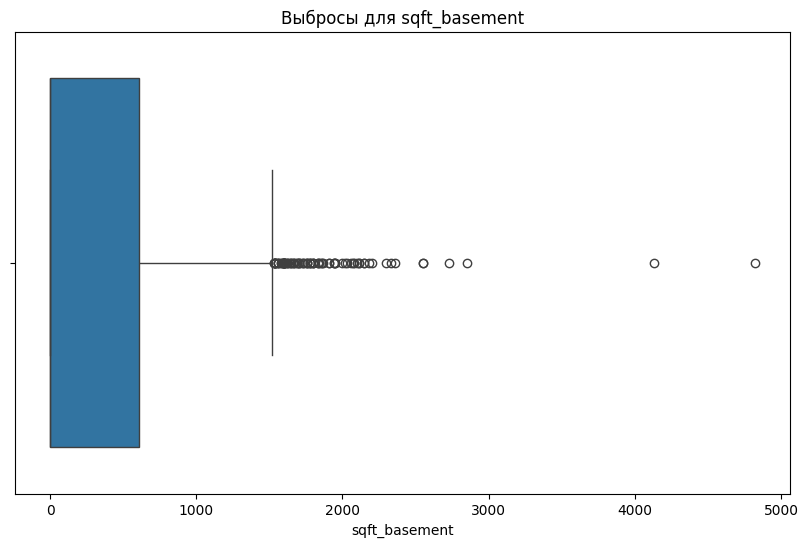

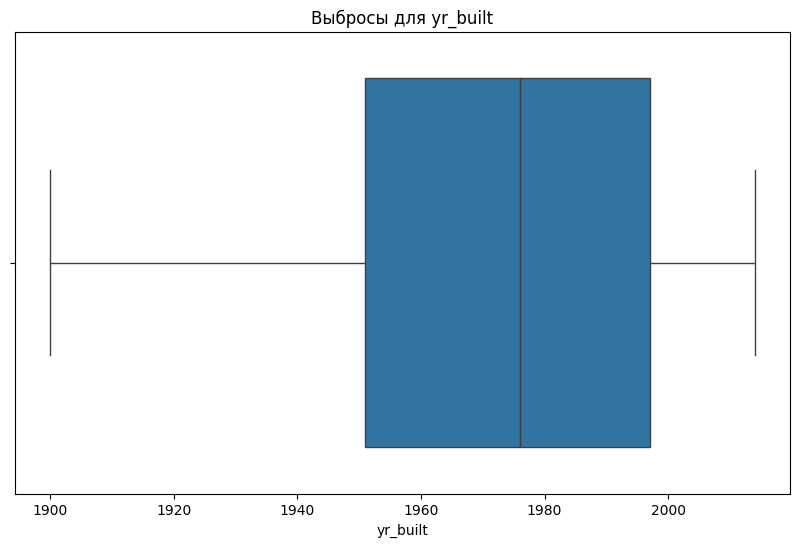

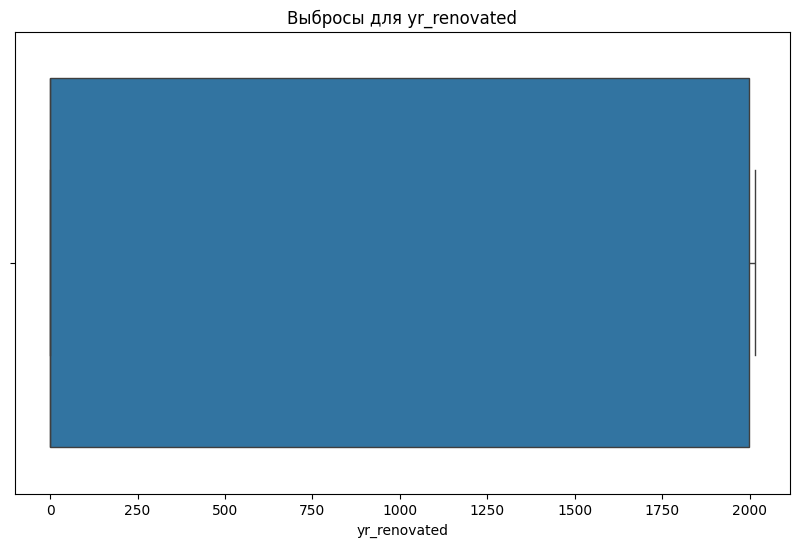

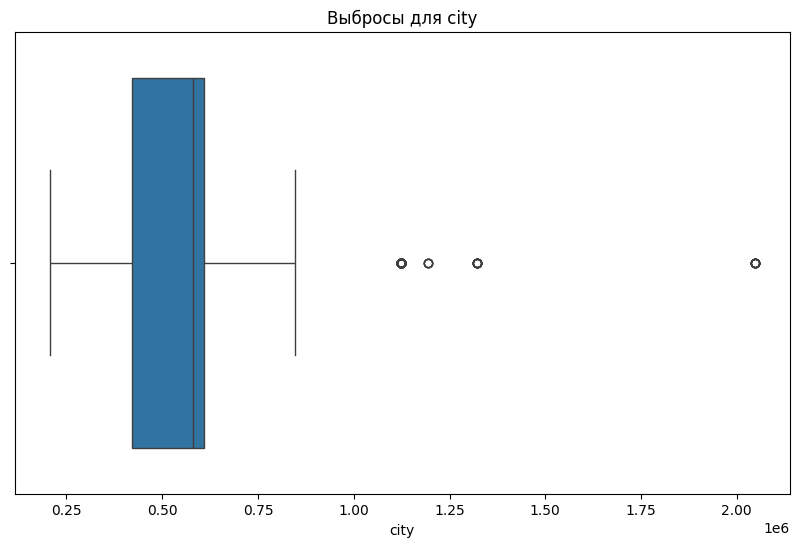

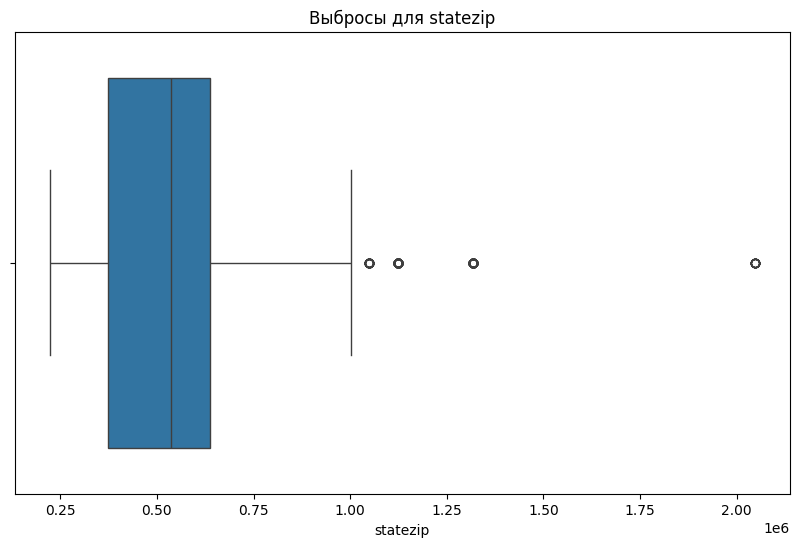

In [ ]:
print("Графики выбросов для данных регрессии")
for column in df_reg.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_reg[column])
    plt.title(f"Выбросы для {column}")
    plt.show()

Проанализировав boxplot для датасета регреси можно сделать следующие выводы:
1. Попробуем прологарифмировать целевую переменную price т.к. она имеет большой разбросом и данные в основном смещены вправо
2. Удалить признак sqft_lot, condition из-за низкой корреляции
3. Попробуем перевести признак waterfront в бинарный
4. Обрежем выбросы для bedrooms и bathrooms

### Обучим модели на улучшенном бейзлайне

Сначала подготовим наши датасеты

In [ ]:
from imblearn.over_sampling import SMOTE

df_class = pd.read_csv("/root/.cache/kagglehub/datasets/yasserh/wine-quality-dataset/versions/1/WineQT.csv")
df_class = df_class.drop(columns=['Id'])

df_class = df_class.drop(columns=['residual sugar', 'pH'])

df_class['chlorides'] = np.log1p(df_class['chlorides'])
df_class['sulphates'] = np.log1p(df_class['sulphates'])

df_class['sulfur_ratio'] = df_class['free sulfur dioxide'] / df_class['total sulfur dioxide']

y_class = df_class['quality']
X_class = df_class.drop(columns=['quality'])

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.3, random_state=5435, shuffle=True
)

# Для oversampling используем SMOTE
smote = SMOTE(random_state=5353, k_neighbors=4)
X_train_class, y_train_class = smote.fit_resample(X_train_class, y_train_class)
scaler = StandardScaler()
X_train_class = scaler.fit_transform(X_train_class)
X_test_class = scaler.transform(X_test_class)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
df_reg = pd.read_csv("/root/.cache/kagglehub/datasets/shree1992/housedata/versions/2/data.csv")
df_reg = df_reg.drop(columns=['street', 'country', 'date'])

df_reg['price'] = np.log1p(df_reg['price'])

df_reg = df_reg.drop(columns=['sqft_lot', 'condition'])
df_reg['waterfront'] = df_reg['waterfront'].apply(lambda x: 1 if x > 0 else 0)

bedroom_upper_limit = df_reg['bedrooms'].quantile(0.95)
bathroom_upper_limit = df_reg['bathrooms'].quantile(0.95)

df_reg = df_reg[
    (df_reg['bedrooms'] <= bedroom_upper_limit) &
    (df_reg['bathrooms'] <= bathroom_upper_limit)
]

categorical_features = ['city', 'statezip']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(df_reg[categorical_features])
encoded_cols = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoder.transform(df_reg[categorical_features]), columns=encoded_cols, index=df_reg.index)
df_reg = pd.concat([df_reg.drop(columns=categorical_features), encoded_df], axis=1)

y_reg = df_reg['price']
X_reg = df_reg.drop(columns=['price'])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=54356, shuffle=True
)
X_train_reg = scaler_reg.fit_transform(X_train_reg)
X_test_reg = scaler_reg.transform(X_test_reg)

Обучим модель для классификации

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
log_reg = LogisticRegression(max_iter=10000, random_state=43643)
param_grid_log_reg = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'class_weight': [None, 'balanced']
}

cv_log_reg = KFold(n_splits=5, shuffle=True, random_state=43643)

grid_search_log_reg = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_log_reg,
    scoring='accuracy',
    cv=cv_log_reg,
    n_jobs=-1
)

grid_search_log_reg.fit(X_train_class, y_train_class)

log_reg_improve = grid_search_log_reg.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
250 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/

Теперь обучим модель для регрессии

In [ ]:
lin_reg_improve = LinearRegression()
lin_reg_improve.fit(X_train_reg, y_train_reg)

LinearRegression()

### Оценим результаты новых моделей на улучшенном бейзлайне

In [ ]:
log_reg_preds = log_reg_improve.predict(X_test_class)
log_reg_acc = accuracy_score(y_test_class, log_reg_preds)
log_reg_f1 = f1_score(y_test_class, log_reg_preds, average='weighted')

print(f"Logistic Regression (Classification) - Accuracy: {log_reg_acc}, F1 Score: {log_reg_f1}")

Logistic Regression (Classification) - Accuracy: 0.4868804664723032, F1 Score: 0.5416818997877059


Заметим, что в прошлой лабораторной работе в результате изменения бейзлайна модель чуть лучше показала себя при измении бейзлайна. Возможно это связано с особенностями модели

In [ ]:
lin_reg_preds = lin_reg_improve.predict(X_test_reg)
lin_reg_preds_exp = np.expm1(lin_reg_preds)
y_test_reg_exp = np.expm1(y_test_reg)

lin_reg_rmse = root_mean_squared_error(y_test_reg_exp, lin_reg_preds_exp)
lin_reg_r2 = r2_score(y_test_reg_exp, lin_reg_preds_exp)

print(f"Linear Regression (Regression) - RMSE: {lin_reg_rmse}, R^2: {lin_reg_r2}")

Linear Regression (Regression) - RMSE: 211577.87489636074, R^2: 0.544210215235696


В задаче регрессии модель не сильно прибавило в точности, по сравнению с прошлой лабораторной. Несмотря на это параметр R^2 достаточно сильно вырос

### Сравнение двух бейзлайнов

- Классификация

| Logistic | Первый baseline | Улучшенный baseline |
|----------|-----------------|---------------------|
| Accuracy |  0.5590         | 0.4868              |
| F1       |  0.5337         | 0.5416              |

Как можем заметить, на улучшенном модель потеряла в accuracy но показала себя примерно также в F1. Можно сделать вывод, что улучшения бейзлана не сильно влияют на точность, ввиду особенность датасета (неравномерном количестве предсказываемых классов)

- Регрессия

|Linear | Первый baseline | Улучшенный baseline  |
|-------|-----------------|----------------------|
| RMSE  | 749683.74       | 211577.87            |
| $R^2$ | 0.1210          | 0.5442               |

В задаче регрессии после работы с фичами модель стала показывать себя намного лучше

## 4.	Имплементация алгоритма машинного обучения

Теперь реализуем свои версии алгоритмов машинного обучения.
Сделаем по 2 версии каждого алгоритма - для классификации и для регрессии

Линейная регрессия

In [ ]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, iterations=10000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.iterations):
            y_pred = np.dot(X, self.weights) + self.bias

            dw = (1 / self.m) * np.dot(X.T, (y_pred - y))
            db = (1 / self.m) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

Логистическая регрессия

In [ ]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=10000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Для многоклассовой реализации будем использовать функцию softmax
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.classes = np.unique(y)
        self.weights = np.zeros((len(self.classes), self.n))
        self.bias = np.zeros(len(self.classes))

        y_encoded = np.zeros((self.m, len(self.classes)))
        for idx, cls in enumerate(self.classes):
            y_encoded[:, idx] = (y == cls).astype(int)

        for _ in range(self.iterations):
            linear_model = np.dot(X, self.weights.T) + self.bias
            y_pred = self.softmax(linear_model)

            dw = (1 / self.m) * np.dot((y_pred - y_encoded).T, X)
            db = (1 / self.m) * np.sum(y_pred - y_encoded, axis=0)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights.T) + self.bias
        y_pred = self.softmax(linear_model)
        return self.classes[np.argmax(y_pred, axis=1)]

Используем базовые датасеты без использования улучшенных техник

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df_class = pd.read_csv("/root/.cache/kagglehub/datasets/yasserh/wine-quality-dataset/versions/1/WineQT.csv")
df_class = df_class.drop(columns=['Id'])
y_class = df_class['quality']
X_class = df_class.drop(columns=['quality'])
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=7575, shuffle = True
)
scaler = MinMaxScaler()
y_train_class = y_train_class.to_numpy()
y_test_class = y_test_class.to_numpy()
X_train_class = scaler.fit_transform(X_train_class)
X_test_class = scaler.transform(X_test_class)

In [ ]:
X_train_class[0]

array([0.6460177 , 0.17808219, 0.51      , 0.07534247, 0.18196995,
       0.08955224, 0.04946996, 0.69970631, 0.39370079, 0.25748503,
       0.30769231])

In [ ]:
df_reg = pd.read_csv("/root/.cache/kagglehub/datasets/shree1992/housedata/versions/2/data.csv")
df_reg = df_reg.drop(columns=['street', 'country', 'date'])

categorical_features = ['city', 'statezip']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoder.fit(df_reg[categorical_features])
encoded_cols = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoder.transform(df_reg[categorical_features]), columns=encoded_cols, index=df_reg.index)

df_reg = pd.concat([df_reg.drop(columns=categorical_features), encoded_df], axis=1)

y_reg = df_reg['price']
X_reg = df_reg.drop(columns=['price'])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=4668, shuffle=True
)
scaler_reg = MinMaxScaler()
X_train_reg = scaler_reg.fit_transform(X_train_reg)
X_test_reg = scaler_reg.transform(X_test_reg)

Обучим все 4 модели

In [ ]:
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train_class, y_train_class)

In [ ]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_reg, y_train_reg)

Оценим результаты работ модели

In [ ]:
y_test_pred = logistic_classifier.predict(X_test_class)
test_accuracy = accuracy_score(y_test_class, y_test_pred)
test_f1 = f1_score(y_test_class, y_test_pred, average='weighted')
print(f"Logistic Regression Classifier - Accuracy: {test_accuracy}, F1 Score: {test_f1}")

y_pred_linear_reg = linear_regressor.predict(X_test_reg)
linear_rmse = root_mean_squared_error(y_test_reg, y_pred_linear_reg)
linear_r2 = r2_score(y_test_reg, y_pred_linear_reg)
print(f"Linear Regression Regressor - RMSE: {linear_rmse}, R^2: {linear_r2}")

Logistic Regression Classifier - Accuracy: 0.5458515283842795, F1 Score: 0.48062199333850303
Linear Regression Regressor - RMSE: 751253.833192247, R^2: 0.11736222660728002


На первый взгляд результаты работы модели достаточно сильно похожи на библиотечную. В задаче классификации имплементация имеет достаточно высокую точность

- Классификация

| Logistic | Библиотека      | Имплементация       |
|----------|-----------------|---------------------|
| Accuracy | 0.5590          | 0.5458              |
| F1       | 0.5337          | 0.4806              |

- Регрессия

| Linear | Библиотека      | Имплиментация     |
|--------|-----------------|-------------------|
| RMSE   | 749683.74       |  751253.83        |
| $R^2$  | 0.1210          | 0.1173            |

Можем заметить, что в принципе имплементация и реализация показываются себя очень похоже кроме F1 меры. Сам алгоритм достаточно простой и не использует большое число гиперпараметров, поэтому отличия не существенные

### Обучим имплементированные модели на улучшенном бейзлайне

In [ ]:
from imblearn.over_sampling import SMOTE

df_class = pd.read_csv("/root/.cache/kagglehub/datasets/yasserh/wine-quality-dataset/versions/1/WineQT.csv")
df_class = df_class.drop(columns=['Id'])

df_class = df_class.drop(columns=['residual sugar', 'pH'])

df_class['chlorides'] = np.log1p(df_class['chlorides'])
df_class['sulphates'] = np.log1p(df_class['sulphates'])

df_class['sulfur_ratio'] = df_class['free sulfur dioxide'] / df_class['total sulfur dioxide']

y_class = df_class['quality']
X_class = df_class.drop(columns=['quality'])

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.3, random_state=5435, shuffle=True
)

# Для oversampling используем SMOTE
smote = SMOTE(random_state=5353, k_neighbors=4)
X_train_class, y_train_class = smote.fit_resample(X_train_class, y_train_class)
scaler = StandardScaler()
X_train_class = scaler.fit_transform(X_train_class)
X_test_class = scaler.transform(X_test_class)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
df_reg = pd.read_csv("/root/.cache/kagglehub/datasets/shree1992/housedata/versions/2/data.csv")
df_reg = df_reg.drop(columns=['street', 'country', 'date'])

df_reg['price'] = np.log1p(df_reg['price'])

df_reg = df_reg.drop(columns=['sqft_lot', 'condition'])
df_reg['waterfront'] = df_reg['waterfront'].apply(lambda x: 1 if x > 0 else 0)

bedroom_upper_limit = df_reg['bedrooms'].quantile(0.95)
bathroom_upper_limit = df_reg['bathrooms'].quantile(0.95)

df_reg = df_reg[
    (df_reg['bedrooms'] <= bedroom_upper_limit) &
    (df_reg['bathrooms'] <= bathroom_upper_limit)
]

categorical_features = ['city', 'statezip']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(df_reg[categorical_features])
encoded_cols = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoder.transform(df_reg[categorical_features]), columns=encoded_cols, index=df_reg.index)
df_reg = pd.concat([df_reg.drop(columns=categorical_features), encoded_df], axis=1)

y_reg = df_reg['price']
X_reg = df_reg.drop(columns=['price'])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=54356, shuffle=True
)
X_train_reg = scaler_reg.fit_transform(X_train_reg)
X_test_reg = scaler_reg.transform(X_test_reg)

После подготовки датасета обучим улучшенные модели

In [ ]:
logistic_classifier_improve = LogisticRegression()
logistic_classifier_improve.fit(X_train_class, y_train_class)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_model = None
best_accuracy = 0
scores = []

X_train_class = np.array(X_train_class)
y_train_class = np.array(y_train_class)

for train_index, val_index in kf.split(X_train_class):
    X_train_fold, X_val_fold = X_train_class[train_index], X_train_class[val_index]
    y_train_fold, y_val_fold = y_train_class[train_index], y_train_class[val_index]

    logistic_classifier = LogisticRegression()
    logistic_classifier.fit(X_train_fold, y_train_fold)

    y_pred = logistic_classifier.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_pred)
    scores.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = logistic_classifier

logistic_classifier_improve = best_model

In [ ]:
linear_regressor_improve = LinearRegression()
linear_regressor_improve.fit(X_train_reg, y_train_reg)

Посмотрим метрики новых моделей

In [ ]:
y_pred_logistic_class = logistic_classifier_improve.predict(X_test_class)
logistic_acc = accuracy_score(y_test_class, y_pred_logistic_class)
logistic_f1 = f1_score(y_test_class, y_pred_logistic_class, average='weighted')
print(f"Logistic Regression Classifier Improve - Accuracy: {logistic_acc}, F1 Score: {logistic_f1}")

y_pred_linear_reg = linear_regressor_improve.predict(X_test_reg)
lin_reg_preds_exp = np.expm1(y_pred_linear_reg)
y_test_reg_exp = np.expm1(y_test_reg)
linear_rmse = root_mean_squared_error(y_test_reg_exp, lin_reg_preds_exp)
linear_r2 = r2_score(y_test_reg_exp, lin_reg_preds_exp)
print(f"Linear Regression Regressor Improve - RMSE: {linear_rmse}, R^2: {linear_r2}")

Logistic Regression Classifier Improve - Accuracy: 0.48104956268221577, F1 Score: 0.5324650492298311
Linear Regression Regressor Improve - RMSE: 240692.48359065558, R^2: 0.4101397338333995


Регрессионная модель показала сильный рост метрики R^2

### Сравнение моделей на улучшенном бейзлане

- Классификация

| Logistic | Библиотека      | Имплементация       |
|----------|-----------------|---------------------|
| Accuracy | 0.4868          | 0.4810              |
| F1       | 0.5352          | 0.5324              |

- Регрессия

| Linear | Библиотека      | Имплиментация     |
|--------|-----------------|-------------------|
| RMSE   | 211577.87       | 240692.48         |
| $R^2$  | 0.5442          | 0.4101            |

Как можем заметить в данной лабораторной работе отличая имплементации и библиотеки минимальные.

В целом по лабораторной работе можно сказать, что удалось сильно улучшить бейзлайн для задачи регрессии. В задаче классификации изменение бейзлайна чуть ухудшило точность, но в целом по классам произошел рост параметра F1 на библиотечной функции, т.к. при использовании техники Oversampling модель стала чуть лучше справляться со всеми классами. Реализация же своих моделей не сильной отличается от библиотечных